# Part 1, Topic 2: Clock Glitching to Dump Memory (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, we learned how clock glitching can be used to get a microcontroller to corrupt variables and skip instructions. This time, we'll look at a more practical example: getting an example bootloader to dump a large chunk of memory.*

**LEARNING OUTCOMES:**

* Applying previous glitch settings to new firmware
* Checking for success and failure when glitching
* Understanding how compiler optimizations can cause devices to behave in strange ways

## The Situation

You should already know the situation from your previous attempts at glitching this bootloader (as well as what the flaw is). No need to do big long searches for parameters, just use values that worked well for the previous tutorial.

In [26]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'

In [27]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/bootloader-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

rm -f -- bootloader-CWLITEXMEGA.hex
rm -f -- bootloader-CWLITEXMEGA.eep
rm -f -- bootloader-CWLITEXMEGA.cof
rm -f -- bootloader-CWLITEXMEGA.elf
rm -f -- bootloader-CWLITEXMEGA.map
rm -f -- bootloader-CWLITEXMEGA.sym
rm -f -- bootloader-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- bootloader.s decryption.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- bootloader.d decryption.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- bootloader.i decryption.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc.exe (WinAVR 20100110) 4.3.3
Copyright (C) 2008 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: bootloader.c
avr-gcc -c -mmcu=atxmega128d3 -I. -fpack-struct -gdwarf-2 -DHAL_TYPE=HAL_xmega -DPLATFORM=CWLITEXMEGA -DF_CPU=7372800

In [28]:
%run "../../Helper_Scripts/Setup_Generic.ipynb"

INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
Serial baud rate = 38400
INFO: Found ChipWhisperer😍


Traceback (most recent call last):
  File "c:\users\adewar\code\chipwhisperer\software\chipwhisperer\hardware\naeusb\naeusb.py", line 283, in txrx
    self.usbdev().ctrl_transfer(payload[0], payload[1], payload[2], payload[3], payload[5:], timeout=self._timeout)
  File "C:\Users\adewar\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\usb\core.py", line 1043, in ctrl_transfer
    self.__get_timeout(timeout))
  File "C:\Users\adewar\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\usb\backend\libusb0.py", line 593, in ctrl_transfer
    timeout
  File "C:\Users\adewar\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\usb\backend\libusb0.py", line 431, in _check
    raise USBError(errmsg, ret)
usb.core.USBError: [Errno None] b'libusb0-dll:err [control_msg] sending control message failed, win error: The device does not recognize the command.\r\n\n'


In [29]:
fw_path = "../../../hardware/victims/firmware/bootloader-glitch/bootloader-{}.hex".format(PLATFORM)

In [30]:
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1663 bytes


In [31]:
if PLATFORM == "CWLITEXMEGA":
    scope.clock.clkgen_freq = 32E6
    target.baud = 38400*32/7.37
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.05)
        scope.io.pdic = "high_z"
        time.sleep(0.05)
        #Flush garbage too
        target.flush()
else:
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = True
        time.sleep(0.05)
        #Flush garbage too
        target.flush()

Serial baud rate = 166729.98643147896


It doesn't look like anything too crazy is going on here - it's probably just printing some characters in a loop. Some ideas:

* If we glitch at the beginning of the loop, we might be able to corrupt the loop length variable and get it to print some extra memory
* We might be able to corrupt the loop variable and get it to read past where it's supposed to

Try selecting a few hundred cycles at the beginning and end of the loop.

**HINT: The last part of the loop should be near the beginning of the last power spike.**

**HINT: If you're really stuck on where the serial print ends, you can find the time between the `trigger_high()` and `trigger_low()` call with `scope.adc.trig_count`.**

In [34]:
glitch_spots = []
glitch_spots.extend([i for i in range(9600, 9650, 1)])

In [35]:
print(glitch_spots)

[9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9647, 9648, 9649]


Now the rest is up to you! 

In [36]:
#Basic setup
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "glitch_only" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called

scope.io.glitch_hp = True
scope.io.glitch_lp = True
print(scope.glitch)

clk_src     = clkgen
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = glitch_only



In [37]:
if SCOPETYPE == "OPENADC":
    scope.clock.adc_src = "clkgen_x1"
    
target.write("p516261276720736265747267206762206f686c207a76797821\n")

In [38]:
def my_print(text):
    for ch in text:
        if (ord(ch) > 31 and ord(ch) < 127) or ch == "\n": 
            print(ch, end='')
        else:
            print("0x{:02X}".format(ord(ch)), end='')
        print("", end='')

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

<IPython.core.display.Javascript object>


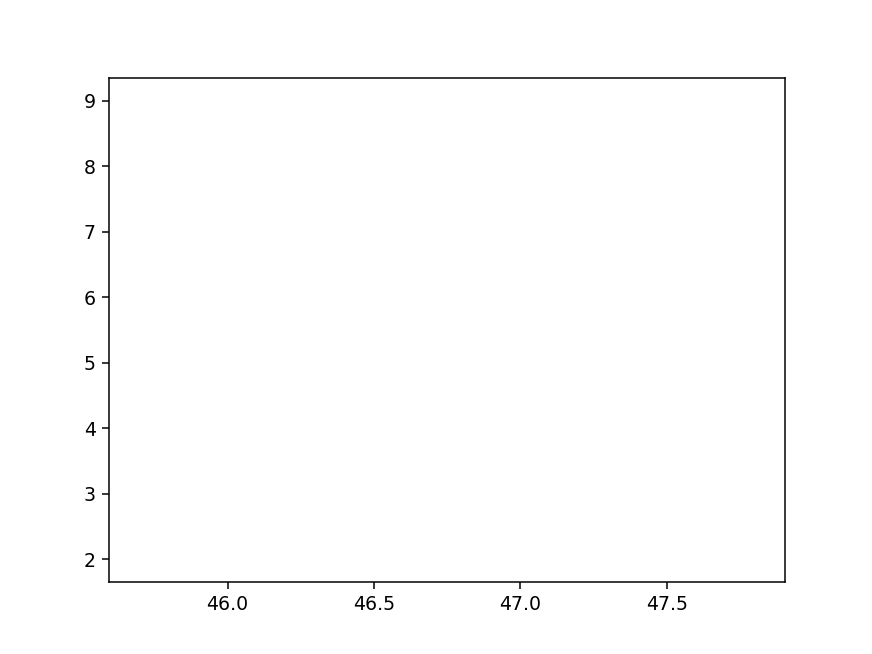

In [39]:
# GlitchController will be part of ChipWhisperer core - just run this block
# for now.


import matplotlib.pylab as plt

import ipywidgets as widgets          
import chipwhisperer.common.results.glitch as glitch

class GlitchController(object):
    
    def __init__(self, groups, parameters):
        self.groups = groups
        self.parameters = parameters
        
        self.results = glitch.GlitchResults(groups=groups, parameters=parameters)
        
        self.parameter_min = [0.0] * len(parameters)
        self.parameter_max = [10.0] * len(parameters)
        self.steps = [1]
        
        self.widget_list_parameter = None
        self.widget_list_groups = None
        
        self.clear()
        
    def clear(self):
        self.results.clear()        
        self.group_counts = [0] * len(self.groups)
        
        if self.widget_list_groups:
            for w in self.widget_list_groups:
                w.value = 0
        
    def set_range(self, parameter, low, high):
        
        if high < low:
            t = low
            low = high
            high = t
        
        i = self.parameters.index(parameter)
        self.parameter_min[i] = low
        self.parameter_max[i] = high
        
        if self.widget_list_parameter:
            # When changing them, need to ensure we don't have min > max ever or will throw
            # an error, so we set max to super-high first.
            self.widget_list_parameter[i].max = 1E9
            self.widget_list_parameter[i].min = low
            self.widget_list_parameter[i].max = high
    
    def set_step(self, parameter, step):
        '''Set size, can be either a single value or a list of step-sizes to iterate through'''
        raise NotImplementedError("TODO")
        
    def set_global_step(self, steps):
        '''Set step for all parameters (Eventually support per-parameter)'''
        if hasattr(steps, "__iter__"):
            self.steps = steps
        else:
            self.steps = [steps]
    
    def add(self, group, parameters, strdesc=None, metadata=None):
        self.results.add(group, parameters, strdesc, metadata)    
        
        i = self.groups.index(group)        
        #Basic count
        self.group_counts[i] += 1
        self.widget_list_groups[i].value =  self.group_counts[i]
    
    def display_stats(self):
        
        self.widget_list_groups = [widgets.IntText(value=0, description=group + " count:", disabled=True)
                                   for group in self.groups]
        
        self.widget_list_parameter = [widgets.FloatSlider(
                                            value=self.parameter_min[i],
                                            min=self.parameter_min[i],
                                            max=self.parameter_max[i],
                                            step=0.01,
                                            description=p + " setting:",
                                            disabled=True,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.01f')
                                          for i,p in enumerate(self.parameters)]
            
        display(*(self.widget_list_groups + self.widget_list_parameter))
       
        
    def glitch_values(self, clear=True):
        """Generator returning the given parameter values in order, using the step size (or step list)"""
        
        self.parameter_values = self.parameter_min[:]
        
        if clear:
            self.clear()
        
        for stepsize in self.steps:
            for val in self._loop_rec(0, len(self.parameter_values)-1, stepsize):
                if self.widget_list_parameter:
                    for i,v in enumerate(val):
                        self.widget_list_parameter[i].value = v
                yield val
        
    def _loop_rec(self, parameter_index, final_index, step):
        self.parameter_values[parameter_index] = self.parameter_min[parameter_index]
        if parameter_index == final_index:            
            while self.parameter_values[parameter_index] <= self.parameter_max[parameter_index]:                                
                yield self.parameter_values
                self.parameter_values[parameter_index] += step
        else:
            while self.parameter_values[parameter_index] <= self.parameter_max[parameter_index]: 
                yield from self._loop_rec(parameter_index+1, final_index, step)
                self.parameter_values[parameter_index] += step

        
gc = GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()
#gc.display_controls()


fig = plt.figure()
#plt.plot(-48, 48, ' ')
#plt.plot(48, -48, ' ')
#plt.plot(-48, -48, ' ')
#plt.plot(48, 48, ' ')
#plt.ion()


In [ ]:
%matplotlib notebook
gc = GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()
#gc.display_controls()


fig = plt.figure()
#plt.plot(-48, 48, ' ')
#plt.plot(48, -48, ' ')
#plt.plot(-48, -48, ' ')
#plt.plot(48, 48, ' ')

In [40]:
scope.adc.timeout = 0.1

In [41]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import tqdm
import re
import struct

scope.glitch.width_fine = 0
scope.glitch.offset_fine = 0
#gc.set_range("width", 47.2, 47.8)
gc.set_range("width", 45.7, 47.8)
#gc.set_range("width", 27, 29.8)
#gc.set_range("width", -18, -19.6)

div = 1
#gc.set_range("offset", -46.5/div, -44.8/div)
gc.set_range("offset", 2/div, 9/div)

#scope.glitch.repeat = 5
scope.glitch.repeat=10
div = 1
gc.set_global_step([0.4])

plt.plot(gc.parameter_min[0], gc.parameter_min[1], ' ')
plt.plot(gc.parameter_min[0], gc.parameter_max[1], ' ')
plt.plot(gc.parameter_max[0], gc.parameter_min[1], ' ')
plt.plot(gc.parameter_max[0], gc.parameter_max[1], ' ')
    
for glitch_setting in gc.glitch_values():
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.width = glitch_setting[0]
    for i in tqdm(glitch_spots, leave=False):
        for _ in range(10):
            scope.glitch.ext_offset = i
            if scope.adc.state:
                #print("Timeout, trigger still high!")
                gc.add("reset", (scope.glitch.width, scope.glitch.offset))
                #plt.plot(scope.glitch.width, scope.glitch.ext_offset, 'xr', alpha=1)
                #fig.canvas.draw()

                #Device is slow to boot?
                reboot_flush()
            target.flush()
            scope.arm()
            target.write("p516261276720736265747267206762206f686c207a76797821\n")
            ret = scope.capture()
            if ret:
                #print('Timeout - no trigger')
                gc.add("reset", (scope.glitch.width, scope.glitch.offset))
                #plt.plot(scope.glitch.width, scope.glitch.ext_offset, 'xr', alpha=1)
                #fig.canvas.draw()

                #Device is slow to boot?
                reboot_flush()
            else:
                time.sleep(0.05)
                output = target.read(timeout=2)
                if "767" in output:
                    print("Glitched!\n\tExt offset: {}\n\tOffset: {}\n\tWidth: {}".format(i, scope.glitch.offset, scope.glitch.width))
                    #plt.plot(scope.glitch.width, scope.glitch.ext_offset, '+g')
                    gc.add("success", (scope.glitch.width, scope.glitch.offset))
                    #fig.canvas.draw()
                    broken = True 
                    for __ in range(500):
                        num_char = target.in_waiting()
                        if num_char:
                            my_print(output)
                            output = target.read(timeout=50)
                    time.sleep(1)
                    break
                else:
                    gc.add("normal", (scope.glitch.width, scope.glitch.offset))
                    #plt.plot(scope.glitch.width, scope.glitch.ext_offset, '.k', alpha=0.1)
                    #fig.canvas.draw()


Glitched!
	Ext offset: 9625
	Offset: 7.03125
	Width: 46.09375
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00                                                                                                                

Glitched!
	Ext offset: 9629
	Offset: 7.421875
	Width: 46.09375
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC886c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Glitched!
	Ext offset: 9624
	Offset: 3.125
	Width: 46.484375
r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x01

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC8

0xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x010xC80x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000xF2?50x030x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x090x090x000x00s0x000x000x000x000x000x000x000x000x000x000x020x000x00@
0x000x12z0x000x000x00@0x0C0x000xA10x070x000x000x000x000x000x000x000x000x00S0x00

0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000xFF0xFF0x000x000x000x000x000x000x000x000x000x000x000x000x000x000xFF0xFF0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00

KeyboardInterrupt: 

## Diagnosing the Fault

As you can see by the output, the bootloader has suffered a pretty catastrophic failure! Not only has it spilled the secret, it's also dumped a whole bunch more memory. For a real bootloader, there's probably some pretty juicy stuff in there like encryption/private keys or previously decrypted firmware. Let's start by taking a look at the C source code that sends the error code back:

```C
trigger_high();

int i;
for(i = 0; i < ascii_idx; i++)
{
    putch(ascii_buffer[i]);
}
trigger_low();
state = IDLE;
```

Nothing really looks too unusual here. Before we take a look at the assembly and figure out what went wrong, let's try to make some guesses:

* Maybe the glitch corrupted the `ascii_idx` variable
    * The glitch happened near the end of the loop. It's unlikely the end of loop counter would be reloaded during the loop
* Maybe we skipped the last `i < ascii_idx` check
    * The glitch caused **a lot** of memory to be dumped. If we just skipped the last check it **should** only print an extra character
* i is a signed integer: maybe we corrupted it into being a really large negative number.

That last one seems to be our best theory, so let's go with that.

## The Answer

Let's check the assembly for our booloader. No need to decompile the binary or recompile to assembly, since there's also a listing file created as part of the build process (`*.lss`). This file also contains C, so it makes it easy to search (try something like the `trigger_high()` call). You might notice that instead of doing a `less than or equal` or `less than` comparison like was in our C code, the compiler has instead inserted a `not equal` comparison instead! This means our original guess may not have been correct, as our assumption about what would happen if the last `i < ascii_idx` was skipped doesn't hold. In fact, it's a lot more likely that the last check was skipped (or i was set to some large value) than flipping a particular bit.

This is actually a pretty unexpected change for the compiler to make, espcially since `less than`, `greater than`, and `not equal` are nearly identical instructions in terms of implementation and have both the same instruction size and speed. This showcases an important fact: the C code that you write is not directly translated to assembly. It needs to go through the compiler first, which may drastically change the intended logic of the program.

Now that we know what happened, let's look at some ways to fix it.

### 1. Volatile variables

C includes a keyword for variables called `volatile`, which indicates that the variable may change between accesses and therefore should not have optimizations applied to it. A typical use case for `volatile` is for peripheral registers on embedded devices. It would be really bad, for example, if you were trying to wait for an IO pin to go high in your code, but the compiler decided it would be faster to only check it only once and assume it doesn't change!

Try replacing `int i = 0;` before the print look with `volatile int i = 0;`, recompile, and check the listing file. Is there any other unexpected changes? What about if you consider the use case above (i.e. if `i` was a register instead of a loop variable)? Is there any way the attack might still work? If so, how might you mitigate this?

### 2. Unrolling the loop

Another potential way of solving this issue would be to manually unroll the loop. The message being printed by the bootloader is a constant length of 7 characters, so we could instead write:

```C
int i;
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
```

In fact, this is something the compiler might do on its own to optimize the code, since unrolling a loop like this is faster than the loop version. It's not a good idea to blindly rely on this, however, since the compiler could choose not to make this optimization as well and might change it between builds.

### 3. Checking for invalid characters

Another thing to consider is that the message from the bootloader only has a limited range of characters that it prints. We could instead construct a "safe print" function that only prints newlines, `'r'` and ASCII digits (i.e. `'0'` to `'9'`):

```C
int safe_print(char c)
{
    if ((c == '\n') ||
       ((c >= '0') && (c <= '9')) ||
       (c == 'r')) {
        putch(c);
        return 0;
    }
    return -1; //uh oh!
}
```

It we went this route, it would be a good idea to make the error return a separate buffer with a bunch of null characters at the end.

### 4. More generic methods

More generic ways of defending against glitch attacks (memory guards, for example) are also discussed in the training slides.

In [73]:
scope.dis()
target.dis()

In [ ]:
import numpy as np

In [ ]:
np.argsort()